In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('../data/Drug_Consumption.csv')

# remove ID column and semeron (fictitious drug introduced to identify over-claimers)
df.drop('ID', axis = 1, inplace = True)
df.drop('Semer', axis = 1, inplace = True)

# remove country column, reason see report
df.drop('Country', axis = 1, inplace = True)

# df.head()

In [3]:
all_subs = set(df.columns[12:])

# used legal substance within in last WEEK or more frequent: 1, otherwise: 0
legal = {'Alcohol', 'Caff', 'Choc', 'Legalh', 'Nicotine'}
mapping_legal = {'CL0': 0, 'CL1': 0, 'CL2': 0, 'CL3': 0, 'CL4': 0, 'CL5': 1, 'CL6': 1}
for subs in legal:
    df = df.replace({subs: mapping_legal})

# used illegal substance within in last YEAR or more frequent: 1, otherwise: 0
illegal = all_subs - legal
# print(illegal)
mapping_illegal = {'CL0': 0, 'CL1': 0, 'CL2': 0, 'CL3': 1, 'CL4': 1, 'CL5': 1, 'CL6': 1}
for subs in illegal:
    df = df.replace({subs: mapping_legal})
    
# target variable
df['NumIllegal']= df[list(illegal)].sum(axis=1)

# clean up dataframe
df.drop(list(illegal), axis = 1, inplace = True)

y = df['NumIllegal']
X = df.loc[:, df.columns != 'NumIllegal']

In [4]:
X.head()

,Age,Gender,Education,Ethnicity,Nscore,Escore,Oscore,AScore,Cscore,Impulsive,SS,Alcohol,Caff,Choc,Legalh,Nicotine
0,25-34,M,Doctorate degree,White,-0.67825,1.93886,1.43533,0.76096,-0.14277,-0.71126,-0.21575,1,1,1,0,0
1,35-44,M,Professional certificate/ diploma,White,-0.46725,0.80523,-0.84732,-1.62090,-1.01450,-1.37983,0.40148,1,1,0,0,0
2,18-24,F,Masters degree,White,-0.14882,-0.80615,-0.01928,0.59042,0.58489,-1.37983,-1.18084,0,1,0,0,0
3,35-44,F,Doctorate degree,White,0.73545,-1.63340,-0.45174,-0.30172,1.30612,-0.21712,-0.21575,0,1,1,0,0
4,65+,F,Left school at 18 years,White,-0.67825,-0.30033,-1.55521,2.03972,1.63088,-1.37983,-1.54858,0,1,0,0,1


In [5]:
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.metrics import accuracy_score, f1_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
import pickle

In [6]:
# baseline RMSE
baseline_pred = np.ones(len(y))*np.mean(y)
baseline_pred_round = np.ones(len(y))*np.round(np.mean(y))

baseline_accuracy = accuracy_score(y,np.zeros(len(y))) # predict class 0 for all points
print('The baseline accuracy is:', baseline_accuracy)

baseline_f1 = f1_score(y,np.zeros(len(y)), average = 'macro')
print('The baseline f1 score is:', baseline_f1)

The baseline accuracy is: 0.552547770700637
The baseline f1 score is: 0.08897435897435899


In [7]:
# getting ready for preprocessing
ordinal_ftrs = ['Age','Education']
ordinal_cats = [['18-24', '25-34', '35-44', '45-54', '55-64', '65+'], \
                ['Left school before 16 years', 'Left school at 16 years', 'Left school at 17 years',\
                'Left school at 18 years', 'Some college or university, no certificate or degree',\
                'Professional certificate/ diploma', 'University degree', 'Masters degree', 'Doctorate degree']]

onehot_ftrs = ['Gender','Ethnicity']

std_ftrs = ['Nscore', 'Escore', 'Oscore', 'AScore', 'Cscore', 'Impulsive', 'SS']

prep = ColumnTransformer(
    transformers=[
        ('ord', OrdinalEncoder(categories = ordinal_cats), ordinal_ftrs),
        ('onehot', OneHotEncoder(sparse=False,handle_unknown='ignore',drop='if_binary'), onehot_ftrs),
        ('std', StandardScaler(), std_ftrs)])

In [8]:
# function
def MLpipe_KFold_f1(X, y, clf, param_grid, model_name):    
    num_rs = 10
    test_RMSE = np.zeros(num_rs)
    test_f1 = np.zeros(num_rs)
    final_models = []
    
    for rs in range(num_rs):

        # 80 train and validation, 20 test
        X_other, X_test, y_other, y_test = train_test_split(X, y, test_size = 0.2, random_state = rs)

        # K fold on other
        kf = KFold(n_splits = 4, shuffle = True, random_state = rs)
    
        # preprocess
        X_other = prep.fit_transform(X_other)
        X_test = prep.transform(X_test)

        # standard scale all features
        scaler = StandardScaler()
        X_other = scaler.fit_transform(X_other)
        X_test = scaler.transform(X_test)
        
        # GridSearchCV
        try:
            model = clf(random_state = rs)
        except:
            model = clf()
        pipe = make_pipeline(model)
    
        grid = GridSearchCV(pipe, param_grid, scoring = 'f1_macro',
                            cv=kf, return_train_score = True, n_jobs=-1, verbose=True)

        grid.fit(X_other, y_other)
        # results = pd.DataFrame(grid.cv_results_)
        # print(results)

        print('Best model parameters:',grid.best_params_)
        print('Validation f1 score:',grid.best_score_)
        final_models.append(grid)
        
        # calculate and save the test RMSE
        y_test_pred = final_models[-1].predict(X_test)
        test_f1[rs] = f1_score(y_test, y_test_pred, average = 'macro')
        
        model_rs = model_name + '_' + str(rs)
        file = open('../results/%s.save' %model_rs, 'wb+')
        pickle.dump((grid,X_test,y_test,y_test_pred),file)
        file.close()
        
        feature_names = prep.get_feature_names_out()
        
    return final_models, test_f1, feature_names

In [9]:
# initialize dictionaries to save test scores
all_f1 = {}
all_f1_std = {}
all_f1_std_above = {}

In [10]:
import warnings
warnings.filterwarnings('ignore')

In [11]:
# Model 1: logistic regression

from sklearn.linear_model import LogisticRegression
clf = LogisticRegression

param_grid = {
              'logisticregression__penalty': ['l2'],
              'logisticregression__C': [10, 2, 1.5, 1.25],
              'logisticregression__max_iter': [10000]
              } 

model_name = 'LogisticRegression'
final_models, test_f1, feature_names = MLpipe_KFold_f1(X, y, clf, param_grid, model_name)

all_f1[model_name] = np.mean(test_f1)
print('\nMean of test f1 scores:', all_f1[model_name])

all_f1_std[model_name] = np.std(test_f1)
print('Standard deviation of test f1 scores:', all_f1_std[model_name])

if baseline_f1 < all_f1[model_name]:
    all_f1_std_above[model_name] = (all_f1[model_name] - baseline_f1) / all_f1_std[model_name]
    print('Test f1 score is', all_f1_std_above[model_name], 'standard deviations above the baseline')
else: 
    print('Test f1 score is below baseline')

Fitting 4 folds for each of 4 candidates, totalling 16 fits
Best model parameters: {'logisticregression__C': 2, 'logisticregression__max_iter': 10000, 'logisticregression__penalty': 'l2'}
Validation f1 score: 0.17384855791723672
Fitting 4 folds for each of 4 candidates, totalling 16 fits
Best model parameters: {'logisticregression__C': 2, 'logisticregression__max_iter': 10000, 'logisticregression__penalty': 'l2'}
Validation f1 score: 0.2061995369967938
Fitting 4 folds for each of 4 candidates, totalling 16 fits
Best model parameters: {'logisticregression__C': 1.5, 'logisticregression__max_iter': 10000, 'logisticregression__penalty': 'l2'}
Validation f1 score: 0.1747812795356325
Fitting 4 folds for each of 4 candidates, totalling 16 fits
Best model parameters: {'logisticregression__C': 2, 'logisticregression__max_iter': 10000, 'logisticregression__penalty': 'l2'}
Validation f1 score: 0.1884766049945406
Fitting 4 folds for each of 4 candidates, totalling 16 fits
Best model parameters: {'

In [12]:
# Model 2: KNN classifier 

from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier

param_grid = {
              'kneighborsclassifier__n_neighbors': [3, 5, 10, 50],
              'kneighborsclassifier__weights': ['uniform', 'distance']
              } 

model_name = 'KNeighborsClassifier'
final_models, test_f1, feature_names = MLpipe_KFold_f1(X, y, clf, param_grid, model_name)

all_f1[model_name] = np.mean(test_f1)
print('\nMean of test f1 scores:', all_f1[model_name])

all_f1_std[model_name] = np.std(test_f1)
print('Standard deviation of test f1 scores:', all_f1_std[model_name])

if baseline_f1 < all_f1[model_name]:
    all_f1_std_above[model_name] = (all_f1[model_name] - baseline_f1) / all_f1_std[model_name]
    print('Test f1 score is', all_f1_std_above[model_name], 'standard deviations above the baseline')
else: 
    print('Test f1 score is below baseline')

Fitting 4 folds for each of 8 candidates, totalling 32 fits


/Users/zhangchengyue/opt/anaconda3/envs/data1030_env/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/zhangchengyue/opt/anaconda3/envs/data1030_env/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken w

Best model parameters: {'kneighborsclassifier__n_neighbors': 5, 'kneighborsclassifier__weights': 'distance'}
Validation f1 score: 0.19505960816335186
Fitting 4 folds for each of 8 candidates, totalling 32 fits


/Users/zhangchengyue/opt/anaconda3/envs/data1030_env/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/zhangchengyue/opt/anaconda3/envs/data1030_env/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken w

Best model parameters: {'kneighborsclassifier__n_neighbors': 5, 'kneighborsclassifier__weights': 'distance'}
Validation f1 score: 0.21331587001385213
Fitting 4 folds for each of 8 candidates, totalling 32 fits


/Users/zhangchengyue/opt/anaconda3/envs/data1030_env/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/zhangchengyue/opt/anaconda3/envs/data1030_env/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken w

/Users/zhangchengyue/opt/anaconda3/envs/data1030_env/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/zhangchengyue/opt/anaconda3/envs/data1030_env/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken w

Best model parameters: {'kneighborsclassifier__n_neighbors': 3, 'kneighborsclassifier__weights': 'distance'}
Validation f1 score: 0.1969430164544512
Fitting 4 folds for each of 8 candidates, totalling 32 fits


/Users/zhangchengyue/opt/anaconda3/envs/data1030_env/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/zhangchengyue/opt/anaconda3/envs/data1030_env/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken w

Best model parameters: {'kneighborsclassifier__n_neighbors': 10, 'kneighborsclassifier__weights': 'distance'}
Validation f1 score: 0.1813084536786621
Fitting 4 folds for each of 8 candidates, totalling 32 fits


/Users/zhangchengyue/opt/anaconda3/envs/data1030_env/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/zhangchengyue/opt/anaconda3/envs/data1030_env/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken w

/Users/zhangchengyue/opt/anaconda3/envs/data1030_env/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/zhangchengyue/opt/anaconda3/envs/data1030_env/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken w

Best model parameters: {'kneighborsclassifier__n_neighbors': 3, 'kneighborsclassifier__weights': 'distance'}
Validation f1 score: 0.1988642539965486
Fitting 4 folds for each of 8 candidates, totalling 32 fits


/Users/zhangchengyue/opt/anaconda3/envs/data1030_env/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/zhangchengyue/opt/anaconda3/envs/data1030_env/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken w

Best model parameters: {'kneighborsclassifier__n_neighbors': 5, 'kneighborsclassifier__weights': 'distance'}
Validation f1 score: 0.19561574686696664
Fitting 4 folds for each of 8 candidates, totalling 32 fits


ckages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/zhangchengyue/opt/anaconda3/envs/data1030_env/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keep

/Users/zhangchengyue/opt/anaconda3/envs/data1030_env/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/zhangchengyue/opt/anaconda3/envs/data1030_env/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken w

Best model parameters: {'kneighborsclassifier__n_neighbors': 3, 'kneighborsclassifier__weights': 'distance'}
Validation f1 score: 0.18469739020924808
Fitting 4 folds for each of 8 candidates, totalling 32 fits


/Users/zhangchengyue/opt/anaconda3/envs/data1030_env/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/zhangchengyue/opt/anaconda3/envs/data1030_env/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken w

/Users/zhangchengyue/opt/anaconda3/envs/data1030_env/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/zhangchengyue/opt/anaconda3/envs/data1030_env/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken w

Best model parameters: {'kneighborsclassifier__n_neighbors': 3, 'kneighborsclassifier__weights': 'distance'}
Validation f1 score: 0.1899534792581622
Fitting 4 folds for each of 8 candidates, totalling 32 fits


/Users/zhangchengyue/opt/anaconda3/envs/data1030_env/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/zhangchengyue/opt/anaconda3/envs/data1030_env/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken w

/Users/zhangchengyue/opt/anaconda3/envs/data1030_env/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/zhangchengyue/opt/anaconda3/envs/data1030_env/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken w

Best model parameters: {'kneighborsclassifier__n_neighbors': 10, 'kneighborsclassifier__weights': 'distance'}
Validation f1 score: 0.19508878151944106
Fitting 4 folds for each of 8 candidates, totalling 32 fits


/Users/zhangchengyue/opt/anaconda3/envs/data1030_env/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/zhangchengyue/opt/anaconda3/envs/data1030_env/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken w

/Users/zhangchengyue/opt/anaconda3/envs/data1030_env/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/zhangchengyue/opt/anaconda3/envs/data1030_env/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken w

Best model parameters: {'kneighborsclassifier__n_neighbors': 3, 'kneighborsclassifier__weights': 'distance'}
Validation f1 score: 0.19171474919739906

Mean of test f1 scores: 0.17610127014093896
Standard deviation of test f1 scores: 0.01358504687295492
Test f1 score is 6.413442072108858 standard deviations above the baseline


/Users/zhangchengyue/opt/anaconda3/envs/data1030_env/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/zhangchengyue/opt/anaconda3/envs/data1030_env/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken w

In [13]:
# Model 3: random forest classifier

from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier

param_grid = {
              'randomforestclassifier__max_depth': [5, 10, 15, 20],
              'randomforestclassifier__max_features': [0.1, 0.3, 0.5, 0.7]
              }

model_name = 'RandomForestClassifier'
final_models, test_f1, feature_names = MLpipe_KFold_f1(X, y, clf, param_grid, model_name)

all_f1[model_name] = np.mean(test_f1)
print('\nMean of test f1 scores:', all_f1[model_name])

all_f1_std[model_name] = np.std(test_f1)
print('Standard deviation of test f1 scores:', all_f1_std[model_name])

if baseline_f1 < all_f1[model_name]:
    all_f1_std_above[model_name] = (all_f1[model_name] - baseline_f1) / all_f1_std[model_name]
    print('Test f1 score is', all_f1_std_above[model_name], 'standard deviations above the baseline')
else: 
    print('Test f1 score is below baseline')

Fitting 4 folds for each of 16 candidates, totalling 64 fits
Best model parameters: {'randomforestclassifier__max_depth': 20, 'randomforestclassifier__max_features': 0.5}
Validation f1 score: 0.2004759042731661
Fitting 4 folds for each of 16 candidates, totalling 64 fits
Best model parameters: {'randomforestclassifier__max_depth': 10, 'randomforestclassifier__max_features': 0.7}
Validation f1 score: 0.21809502337801154
Fitting 4 folds for each of 16 candidates, totalling 64 fits
Best model parameters: {'randomforestclassifier__max_depth': 20, 'randomforestclassifier__max_features': 0.7}
Validation f1 score: 0.19048564707277638
Fitting 4 folds for each of 16 candidates, totalling 64 fits
Best model parameters: {'randomforestclassifier__max_depth': 20, 'randomforestclassifier__max_features': 0.5}
Validation f1 score: 0.21512477958049225
Fitting 4 folds for each of 16 candidates, totalling 64 fits
Best model parameters: {'randomforestclassifier__max_depth': 20, 'randomforestclassifier__ma

In [14]:
# Model 4: support vector classifier 

from sklearn.svm import SVC

clf = SVC

param_grid = {
              'svc__gamma': [0.0001, 0.001, 0.01],
              'svc__C': [10, 50, 100, 150]
              }

model_name = 'SVC'
final_models, test_f1, feature_names = MLpipe_KFold_f1(X, y, clf, param_grid, model_name)

all_f1[model_name] = np.mean(test_f1)
print('\nMean of test f1 scores:', all_f1[model_name])

all_f1_std[model_name] = np.std(test_f1)
print('Standard deviation of test f1 scores:', all_f1_std[model_name])

if baseline_f1 < all_f1[model_name]:
    all_f1_std_above[model_name] = (all_f1[model_name] - baseline_f1) / all_f1_std[model_name]
    print('Test f1 score is', all_f1_std_above[model_name], 'standard deviations above the baseline')
else: 
    print('Test f1 score is below baseline')

Fitting 4 folds for each of 12 candidates, totalling 48 fits
Best model parameters: {'svc__C': 150, 'svc__gamma': 0.001}
Validation f1 score: 0.18429871006243065
Fitting 4 folds for each of 12 candidates, totalling 48 fits
Best model parameters: {'svc__C': 100, 'svc__gamma': 0.01}
Validation f1 score: 0.20641385126657938
Fitting 4 folds for each of 12 candidates, totalling 48 fits
Best model parameters: {'svc__C': 50, 'svc__gamma': 0.01}
Validation f1 score: 0.1701259960289652
Fitting 4 folds for each of 12 candidates, totalling 48 fits
Best model parameters: {'svc__C': 150, 'svc__gamma': 0.001}
Validation f1 score: 0.1756386641332308
Fitting 4 folds for each of 12 candidates, totalling 48 fits
Best model parameters: {'svc__C': 100, 'svc__gamma': 0.01}
Validation f1 score: 0.18789231706159687
Fitting 4 folds for each of 12 candidates, totalling 48 fits
Best model parameters: {'svc__C': 100, 'svc__gamma': 0.01}
Validation f1 score: 0.19267259334946737
Fitting 4 folds for each of 12 cand

In [15]:
# Model 5: xgb classifier

from xgboost import XGBClassifier

# define custom f1 score for XGB
# didn't seem to work :(
def f1_eval(y_true, y_pred):
    return 'f1_score', f1_score(y_true, y_pred, average = 'macro')

clf = XGBClassifier

param_grid = {'xgbclassifier__learning_rate': [0.01, 0.03, 0.05],
              'xgbclassifier__max_depth': [5, 10, 15],
              'xgbclassifier__n_estimators': [100],
              'xgbclassifier__use_label_encoder': [False],
              'xgbclassifier__eval_metric': [f1_eval]
             }

model_name = 'XGBClassifier'
final_models, test_f1, feature_names = MLpipe_KFold_f1(X, y, clf, param_grid, model_name)

all_f1[model_name] = np.mean(test_f1)
print('\nMean of test f1 scores:', all_f1[model_name])

all_f1_std[model_name] = np.std(test_f1)
print('Standard deviation of test f1 scores:', all_f1_std[model_name])

if baseline_f1 < all_f1[model_name]:
    all_f1_std_above[model_name] = (all_f1[model_name] - baseline_f1) / all_f1_std[model_name]
    print('Test f1 score is', all_f1_std_above[model_name], 'standard deviations above the baseline')
else: 
    print('Test f1 score is below baseline')

Fitting 4 folds for each of 9 candidates, totalling 36 fits


/Users/zhangchengyue/opt/anaconda3/envs/data1030_env/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/zhangchengyue/opt/anaconda3/envs/data1030_env/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/zhangchengyue/opt/anaconda3/envs/data1030_env/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/zhangchengyue/opt/anaconda3/envs/data1030_env/lib/python3.10/site-packages/xgboost/compat.

[18:46:53] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best model parameters: {'xgbclassifier__eval_metric': <function f1_eval at 0x13ebfa560>, 'xgbclassifier__learning_rate': 0.03, 'xgbclassifier__max_depth': 10, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__use_label_encoder': False}
Validation f1 score: 0.20116306619126714
Fitting 4 folds for each of 9 candidates, totalling 36 fits
[18:47:29] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best model parameters: {'

[18:46:15] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:46:18] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:46:22] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:46:27] WARNING: /Users/runner/miniforge3/c

[18:46:15] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:46:19] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:46:24] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:46:29] WARNING: /Users/runner/miniforge3/c

[18:46:15] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:46:18] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:46:22] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:46:27] WARNING: /Users/runner/miniforge3/c

[18:52:49] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best model parameters: {'xgbclassifier__eval_metric': <function f1_eval at 0x13ebfa560>, 'xgbclassifier__learning_rate': 0.03, 'xgbclassifier__max_depth': 10, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__use_label_encoder': False}
Validation f1 score: 0.1963727868655395
Fitting 4 folds for each of 9 candidates, totalling 36 fits
[18:53:34] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best model parameters: {'x

In [16]:
print('Mean f1 of each model: ', all_f1)
print('Std above baseline for each model: ', all_f1_std_above)

Mean f1 of each model:  {'LogisticRegression': 0.17631945320638565, 'KNeighborsClassifier': 0.17610127014093896, 'RandomForestClassifier': 0.17493619845999372, 'SVC': 0.17382704605122576, 'XGBClassifier': 0.17775773679881057}
Std above baseline for each model:  {'LogisticRegression': 4.699993599570775, 'KNeighborsClassifier': 6.413442072108858, 'RandomForestClassifier': 4.712107798771454, 'SVC': 5.062562579512001, 'XGBClassifier': 5.4947371098412265}


In [17]:
import matplotlib
from matplotlib import pylab as plt
plt.rcParams.update({'font.size': 12})

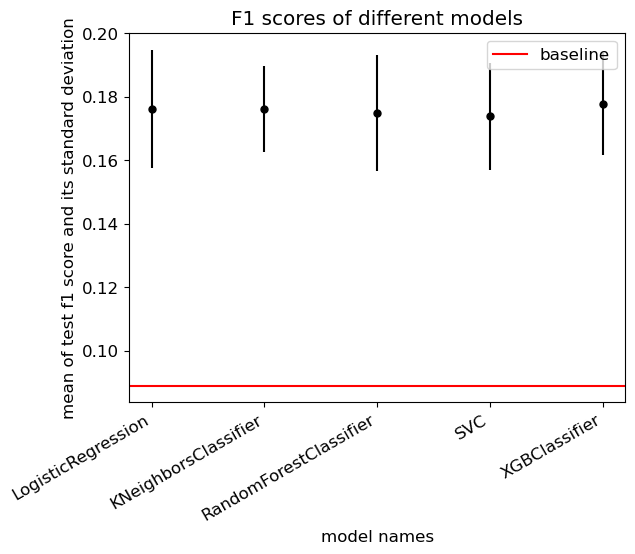

In [18]:
plt.plot()
plt.errorbar(list(all_f1.keys()), list(all_f1.values()), list(all_f1_std.values()), fmt='.k', markersize=10)
plt.axhline(y = baseline_f1, color = 'r', linestyle = '-', label = 'baseline')
plt.legend(loc = 'upper right')
plt.xticks(rotation=30, ha='right')
plt.xlabel('model names')
plt.ylabel('mean of test f1 score and its standard deviation')
plt.title('F1 scores of different models')
plt.savefig('../figures/models_accuracy.png', bbox_inches = "tight") 
plt.show()

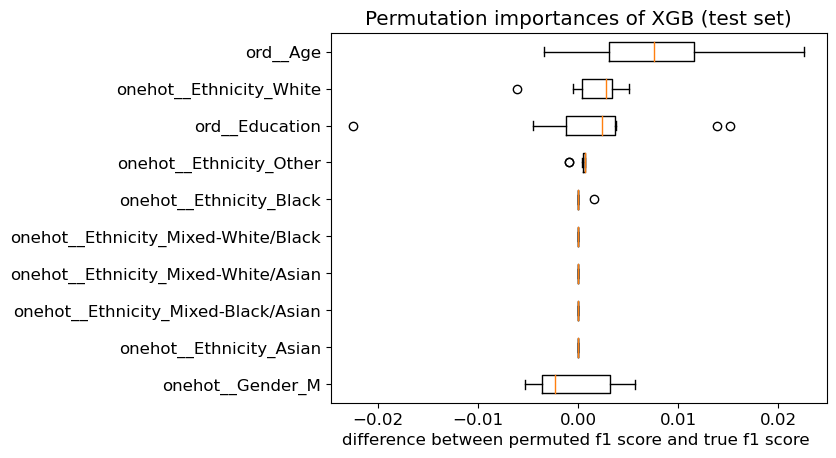

In [27]:
# global feature importance of XGB calculated with permutation importance
from sklearn.inspection import permutation_importance

file = open('../results/XGBClassifier_0.save', 'rb') 
model,X_test,y_test,y_test_pred = pickle.load(file) 
file.close()

result = permutation_importance(estimator=model, X=X_test, y=y_test, scoring = 'f1_macro', n_repeats=10, random_state=6)

sorted_idx = result.importances_mean.argsort()[-10:]

plt.boxplot(result.importances[sorted_idx].T,labels=feature_names[sorted_idx],vert=False)
plt.title('Permutation importances of XGB (test set)')
plt.xlabel('difference between permuted f1 score and true f1 score ')
plt.savefig('../figures/XGB_permutation.png', bbox_inches = "tight") 
plt.show()

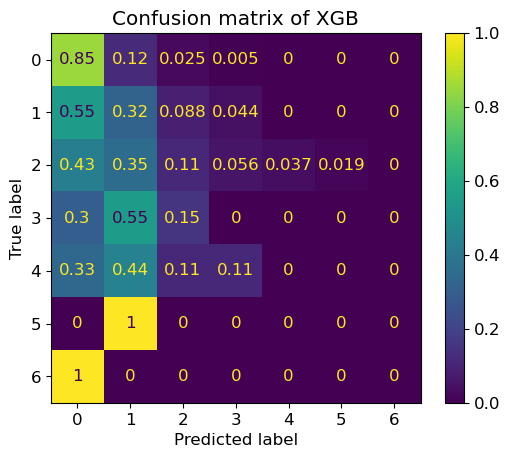

In [28]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
cm = confusion_matrix(y_test,y_test_pred, normalize = 'true')
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.title('Confusion matrix of XGB')
plt.savefig('../figures/XGB_confusion_matrix.png', bbox_inches = "tight") 
plt.show()

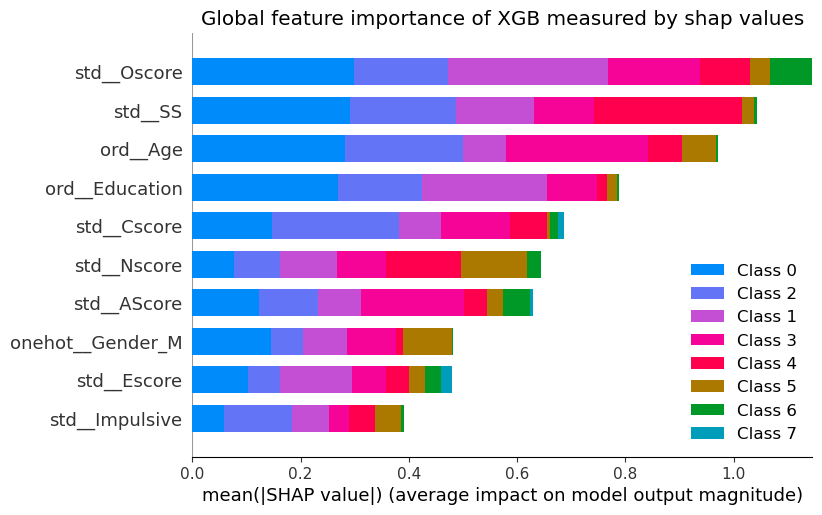

In [29]:
import shap

# global feature importance of RandomForestClassifier calculated with shap
shap.initjs()
explainer = shap.TreeExplainer(model.best_estimator_[0])

# calculate shap values on all points in the test set
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, feature_names = feature_names, max_display = 10, plot_type = 'bar', show = False)
plt.title('Global feature importance of XGB measured by shap values')
plt.savefig('../figures/XGB_shap.png', bbox_inches = "tight") 
plt.show()

In [30]:
y_test = y_test.tolist()

class of interest: 0
true class: 0


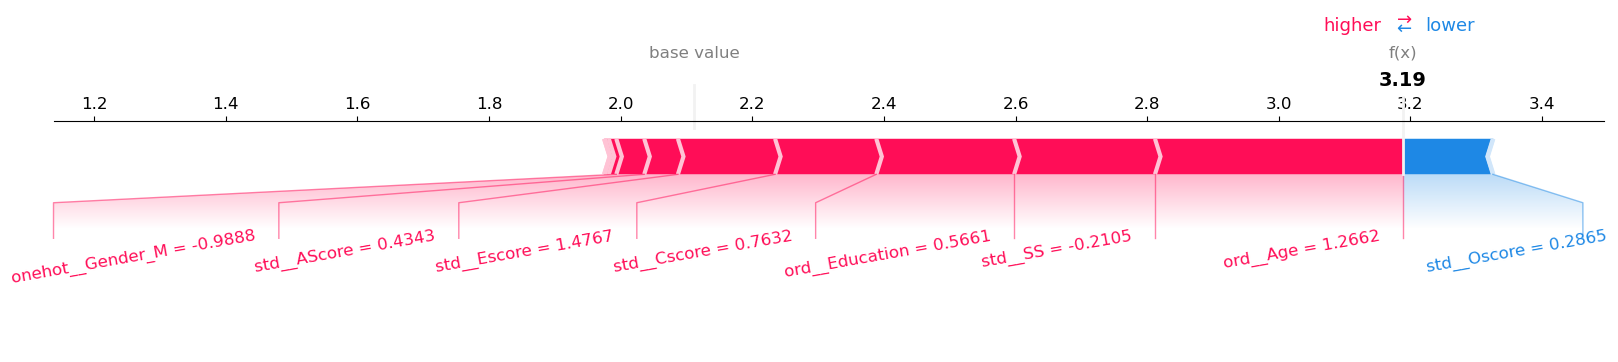

In [49]:
index = 120

prediction = y_test[index]
print('class of interest: 0')
print('true class:', prediction)
shap.force_plot(explainer.expected_value[0], shap_values[0][index][:], features = X_test[index].round(4), feature_names = feature_names, text_rotation=10, matplotlib=True, show=False)
plt.savefig('../figures/shap_1.png', bbox_inches = "tight") 
plt.show()

class of interest: 0
true class: 2


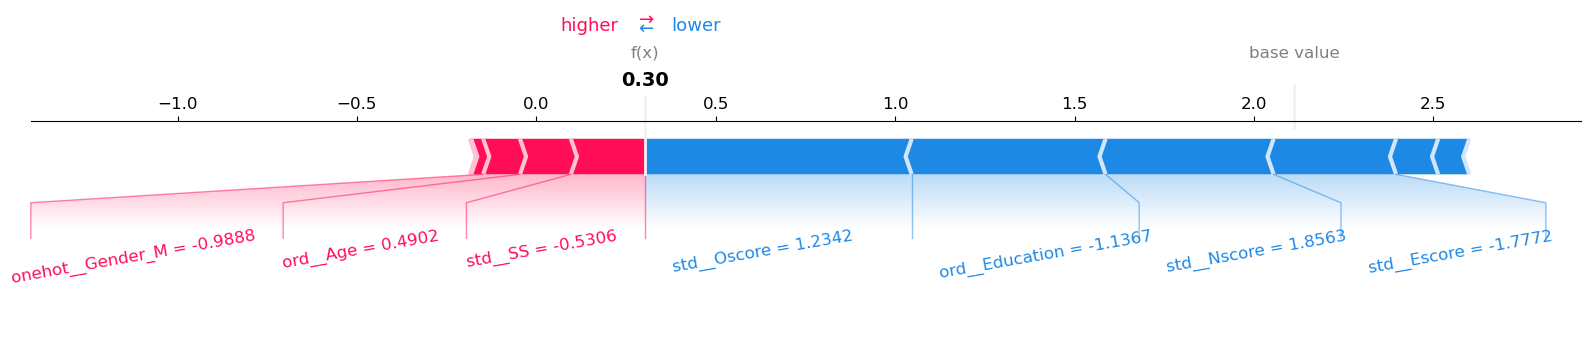

In [50]:
index = 119
prediction = y_test[index]
print('class of interest: 0')
print('true class:', prediction)
shap.force_plot(explainer.expected_value[0], shap_values[0][index][:], features = X_test[index].round(4), feature_names = feature_names, text_rotation=10, matplotlib=True, show=False)
plt.savefig('../figures/shap_2.png', bbox_inches = "tight") 
plt.show()

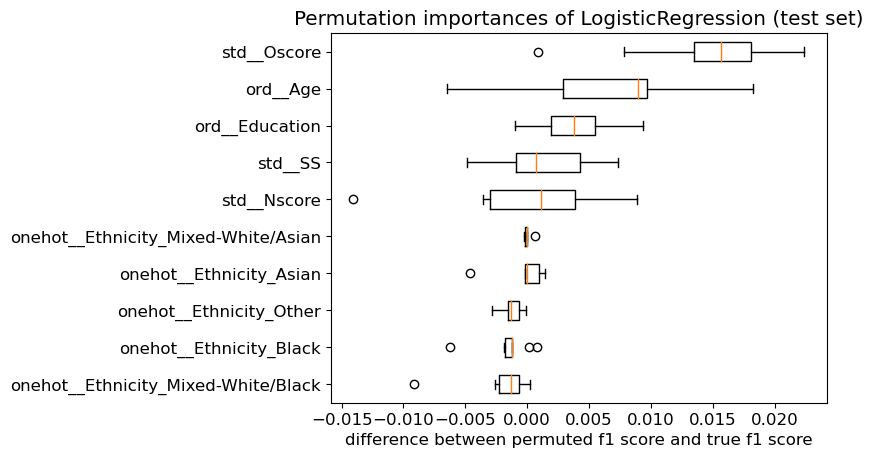

In [52]:
# global feature importance of LogisticRegression calculated with permutation importance
file = open('../results/LogisticRegression_0.save', 'rb') 
model,X_test,y_test,y_test_pred = pickle.load(file) 
file.close()

result = permutation_importance(estimator=model, X=X_test, y=y_test, scoring = 'f1_macro', n_repeats=10, random_state=6)

sorted_idx = result.importances_mean.argsort()[-10:]

plt.boxplot(result.importances[sorted_idx].T,labels=feature_names[sorted_idx],vert=False)
plt.title('Permutation importances of LogisticRegression (test set)')
plt.xlabel('difference between permuted f1 score and true f1 score')
plt.savefig('../figures/LogisticRegression_permutation.png', bbox_inches = "tight") 
plt.show()

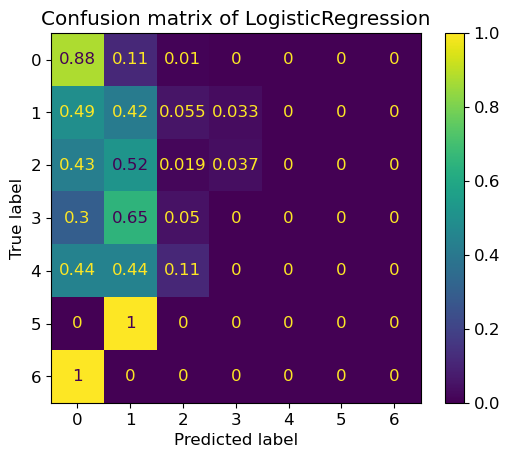

In [53]:
cm = confusion_matrix(y_test,y_test_pred, normalize = 'true')
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.title('Confusion matrix of LogisticRegression')
plt.savefig('../figures/LogisticRegression_confusion_matrix.png', bbox_inches = "tight") 
plt.show()